This notebook compares vanilla RNNs (SimpleRNN in keras) to an LSTM for the cartpole swingup

In [1]:
# Force keras to use the CPU becuase it's actually faster for this size network
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
os.environ["CUDA_VISIBLE_DEVICES"] = ''

import numpy as np
import pandas as pd

from numpy import cos, sin, pi
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Flatten
from tensorflow.keras.constraints import max_norm

from cartpole_class import Cartpole 

/Users/sgillen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
## Define some constants
# time vector, if you use the default solver: doesn't actually affect the integration, only what times it records our state variable at
dt = 0.1
tmax = 8.0
t_eval = np.arange(0.0, tmax, dt)

# Cartpole is a class we defined that takes care of the simulation/animation of the cartpole
bot = Cartpole()

In [5]:
## Run a bunch of trials using the energy shaping controller
num_trials = 5 # This is the number of intital conditions to try, note the total number of trials is num_trials*num_trials

min_theta = 0
max_theta = 0

min_thdot = -1
max_thdot = 1

# we'll iterate through these two
theta_vals = np.linspace(min_theta, max_theta, num_trials)
thdot_vals = np.linspace(min_thdot, max_thdot, num_trials)

# and keep these two constant
x = 0
xdot = 0

states = np.zeros((len(t_eval), num_trials, num_trials, 4))
actions = np.zeros((len(t_eval), num_trials, num_trials, 1))


for i, theta in enumerate(theta_vals):
    for j, thdot in enumerate(thdot_vals):

        # initial state
        init_state = np.array([theta, x, thdot, xdot])
        
        # integrate the ODE (by default this is equivalent to ode45)
        sol = integrate.solve_ivp(bot.derivs, (0,tmax), init_state, t_eval = t_eval, max_step = .1)
        if not sol.success:
            print("warning: solver failed with intial conditions: ", init_state )
        
        # TODO think about doing this without a dimension per changing parameter..
        states[:,i,j,:] = sol.y.T
        
        #TODO, really don't like this
        for t in range(len(t_eval)):
            actions[t,i,j] = bot.control(0, states[t,i,j,:]) 

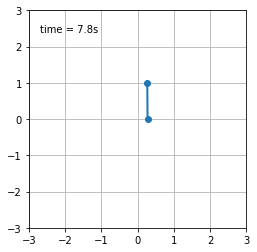

In [7]:
# Animate the cart (optional) 
ani = bot.animate_cart(t_eval, states[:,0,0,:])
HTML(ani.to_jshtml())

In [66]:
#Sample the energy shaping controller states
def sampleData(x, n, Ts):
    """splits up data array x into sets of length n with sampling time Ts
    x:  input matrix (M,N)
    n:  number of samples per set
    Ts: sample time
    """
    N = x.shape[0]                                              #number of input vectors
    z_ext = np.zeros(((n-1)*Ts,x.shape[1]))
    x = np.concatenate((z_ext, x), axis=0)
    #calculate number of sets
    nset = N
    y = np.zeros((nset,)+(x.shape[1],)+(n,))                    #initialize output matrix
    step = 0      
    #iterate through input data                                              
    while(step<nset):
        #select vectors according to n and Ts
        y[step,:,:] = np.transpose(x[step:(n-1)*Ts+1+step:Ts,:]) 
        step+=1                                                 
    return y

look_back = 3
Ts = 1
lb_states = sampleData(states[:,0,0,:], look_back, Ts)

In [214]:
# Create our two RNNs for comparison

# Feed forward 
with tf.variable_scope('pi/simple_pol/'):
    ff_model = Sequential()
    #simple_model.add(SimpleRNN(12, input_shape=(4,look_back)))
    #model.add(LSTM(12, input_shape =(4,look_back)))
    ff_model.add(Dense(12, input_shape=(4,), activation ='relu'))
    ff_model.add(Dense(12, input_shape=(4,), activation ='relu'))
    ff_model.add(Dense(1))

    #model.add(Dense(2))

# LSTM
with tf.variable_scope('pi/simple_pol/'):
    lstm_model = Sequential()
    lstm_model.add(LSTM(12, input_shape =(4,1)))
    lstm_model.add(Dense(1))

    #model.add(Dense(2))

# Feed forward with looking back
with tf.variable_scope('pi/simple_pol/'):
    fflb_model = Sequential()
    fflb_model.add(Flatten())
    fflb_model.add(Dense(12*look_back, activation ='relu'))
    fflb_model.add(Dense(12*look_back, activation ='relu'))
    fflb_model.add(Dense(1))
    

ff_model.compile(loss='mean_squared_error', optimizer='adam')
fflb_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

<Figure size 432x288 with 0 Axes>

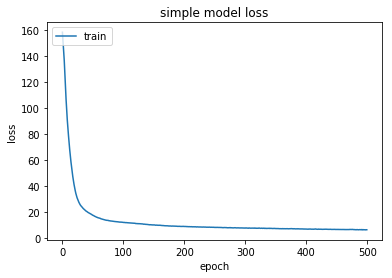

<Figure size 432x288 with 0 Axes>

In [215]:
# Train Feedforward network

ff_history = ff_model.fit(states.reshape(-1,4), actions.reshape(-1,1), epochs=500, verbose=0)
plt.plot(ff_history.history['loss'])
plt.title('simple model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.figure()

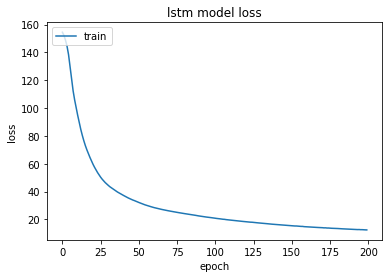

In [216]:
# Train LSTM

lstm_history = lstm_model.fit(states.reshape(-1,4,1), actions.reshape(-1,1), epochs=200, verbose=0)
plt.plot(lstm_history.history['loss'])
plt.title('lstm model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

<Figure size 432x288 with 0 Axes>

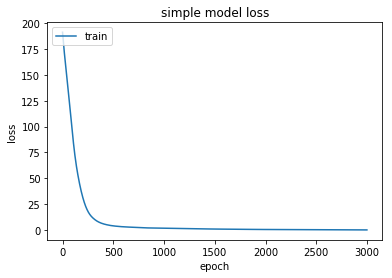

<Figure size 432x288 with 0 Axes>

In [80]:
# Train Feedforward network with looking back

fflb_history = fflb_model.fit(lb_states, actions[:,0,0,:], batch_size = lb_states.shape[0], epochs=3000, verbose=0)
plt.plot(fflb_history.history['loss'])
plt.title('simple model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.figure()

In [217]:
# This is a closure that returns our NN controller


def make_controller(model):
    def nn_controller(t,q):
        if (q[0] < (140 * (pi/180)) ) or (q[0] > (220 * (pi/180)) ):
            return model.predict(q.reshape((1,4,1)))
        else:
            # balancing
            # LQR: K values from MATLAB
            k1 = 140.560
            k2 = -3.162
            k3 = 41.772
            k4 = -8.314
            u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
            return u
        
    return nn_controller


# an ugly hack TODO make this and the one above compatible
def make_ff_controller(model):
    def nn_controller(t,q):
        if (q[0] < (140 * (pi/180)) ) or (q[0] > (220 * (pi/180)) ):
            return model.predict(q.reshape(1,4))
        else:
            # balancing
            # LQR: K values from MATLAB
            k1 = 140.560
            k2 = -3.162
            k3 = 41.772
            k4 = -8.314
            u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
            return u
        
    return nn_controller

def make_fflb_controller(model):
    def nn_controller(t,q):
        if (q[0,look_back-1] < (140 * (pi/180)) ) or (q[0,look_back-1] > (220 * (pi/180)) ):
            u = model.predict(q.reshape(1,q.shape[0],q.shape[1]))
            return u[0][0]
        else:
            # balancing
            # lqr: k values from matlab
            k1 = 140.560
            k2 = -3.162
            k3 = 41.772
            k4 = -8.314
            u = -(k1 * (q[0,look_back-1] - pi) + k2 * q[1,look_back-1] + k3 * q[2,look_back-1] + k4 * q[3,look_back-1])
            return u
        
    return nn_controller


ff_control = make_ff_controller(ff_model)
fflb_control = make_fflb_controller(fflb_model)
lstm_control = make_controller(lstm_model)

ff_bot = Cartpole()
fflb_bot = Cartpole(dt, Ts=1, n=3)
lstm_bot = Cartpole()

ff_bot.control = ff_control
fflb_bot.control = fflb_control
lstm_bot.control = lstm_control

# initial conditions
theta = .4
x = 1
th_dot = .1 # an initial velocity, triggers the swing up control
xdot = 0.1
time = np.arange(0.0, 20, dt)

# initial state
init_state = np.array([theta, x, th_dot, xdot])

In [218]:
def run_and_animate(bot):

    sol = integrate.solve_ivp(bot.derivs, (0,tmax), init_state, t_eval = t_eval)
    states = sol.y.T

    actions = np.zeros(len(t_eval))
    for t in range(len(t_eval)):
            actions[t] = bot.control(t, states[t]) 

    plt.figure()
    plt.plot(states[:,2])

    ani = bot.animate_cart(t_eval, states)
    return ani, states, actions

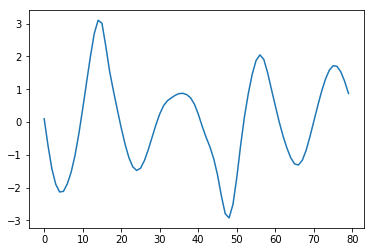

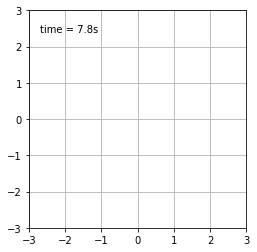

In [219]:
ani, states_ff, actions_ff = run_and_animate(ff_bot)
HTML(ani.to_jshtml())

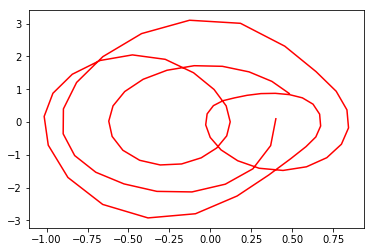

In [220]:
theta_traj = states_ff[:,0]
thdot_traj = states_ff[:,2]
plt.plot(theta_traj, thdot_traj, color='r')   

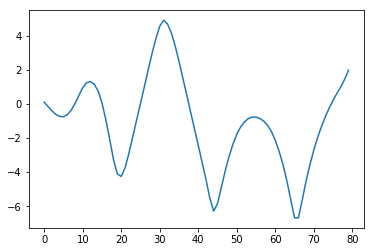

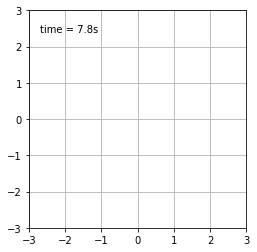

In [222]:
ani, states_lstm, actions_lstm = run_and_animate(lstm_bot)
HTML(ani.to_jshtml())

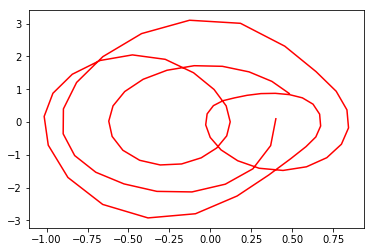

In [223]:
theta_traj = states_ff[:,0]
thdot_traj = states_ff[:,2]
plt.plot(theta_traj, thdot_traj, color='r') 

In [224]:
es_bot = Cartpole()

theta_vals = np.arange(-2.80, 2.2,.1)
thdot_vals = np.arange(-6, 6, .2)
theta_mesh, thdot_mesh = np.meshgrid(theta_vals, thdot_vals)

es_img = np.zeros((theta_vals.size, thdot_vals.size))
for i, theta in enumerate(theta_vals):
    for j,thdot in enumerate(thdot_vals):
        es_img[i,j] = es_bot.control(0, np.array([theta,0,thdot,0]))
        
ff_img = np.zeros((theta_vals.size, thdot_vals.size))
for i, theta in enumerate(theta_vals):
    for j,thdot in enumerate(thdot_vals):
        ff_img[i,j] = ff_bot.control(0, np.array([theta,0,thdot,0]))

lstm_img = np.zeros((theta_vals.size, thdot_vals.size))
for i, theta in enumerate(theta_vals):
    for j,thdot in enumerate(thdot_vals):
        lstm_img[i,j] = lstm_control(0, np.array([theta,0,thdot,0]))      

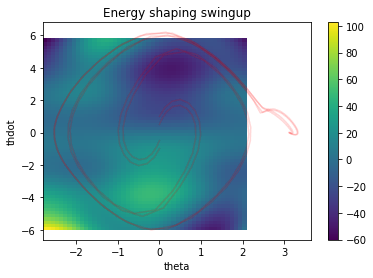

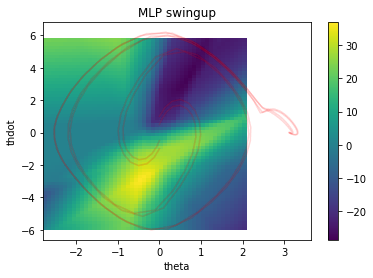

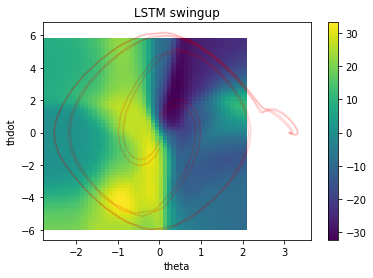

In [225]:
plt.figure()
plt.pcolor(theta_mesh, thdot_mesh, es_img.T)
plt.title('Energy shaping swingup')
plt.ylabel('thdot')
plt.xlabel('theta')
plt.colorbar()
plt.plot()

for i in range(num_trials):
    for j in range(num_trials):
        theta_traj = states[:,i,j,0]
        thdot_traj = states[:,i,j,2]
        plt.plot(theta_traj, thdot_traj, color='r', alpha=.03)   

plt.figure()
plt.pcolor(theta_mesh, thdot_mesh, ff_img.T)
plt.title('MLP swingup')
plt.ylabel('thdot')
plt.xlabel('theta')
plt.colorbar()

for i in range(num_trials):
    for j in range(num_trials):
        theta_traj = states[:,i,j,0]
        thdot_traj = states[:,i,j,2]
        plt.plot(theta_traj, thdot_traj, color='r', alpha=.03)   


plt.figure()
plt.pcolor(theta_mesh, thdot_mesh, lstm_img.T)
plt.title('LSTM swingup')
plt.ylabel('thdot')
plt.xlabel('theta')
plt.colorbar()

for i in range(num_trials):
    for j in range(num_trials):
        theta_traj = states[:,i,j,0]
        thdot_traj = states[:,i,j,2]
        plt.plot(theta_traj, thdot_traj, color='r', alpha=.03)   


#for th, thdot in zip(theta_grid, thdot_grid):

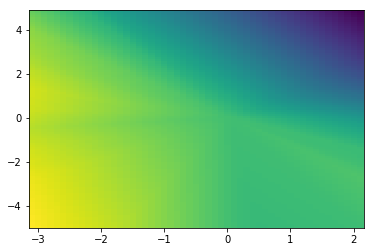

In [155]:
xx, yy = np.meshgrid(theta_vals, thdot_vals)

plt.figure()
plt.pcolor(xx,yy, ff_img.T)

In [182]:
ff_img

array([[ 1.35408759,  1.34306121,  1.33203483, ..., -0.57183927,
        -0.65817398, -0.74064863],
       [ 1.32501006,  1.31398392,  1.30295753, ..., -0.65536022,
        -0.73375934, -0.80274791],
       [ 1.29593277,  1.28490639,  1.27388   , ..., -0.72686952,
        -0.7958582 , -0.85868913],
       ...,
       [-0.09801483, -0.09375286, -0.08949113, ..., -3.4580369 ,
        -3.5214994 , -3.58496261],
       [-0.09431791, -0.09005594, -0.08579385, ..., -3.51466489,
        -3.57812738, -3.64159107],
       [-0.09062052, -0.08635879, -0.08209682, ..., -3.57129264,
        -3.63475561, -3.69821835]])